In [1]:
! pip install --upgrade tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.0
    Uninstalling tensorboard-2.9.0:
      Successfully uninstalled tensorboard-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nerfstudio 0.1.8 requires matplotlib==3.5.3, but you have matplotlib 3.4.3 which is incompatible.
nerfstudio 0.1.8 requires protobuf==3.20.0, but you have protobuf 3.19.6 which is incompatible.
nerfstudio 0.1.8 requires tensorboard==2.9.0, but you have tensorboard 2.11.2 which is incompatible.
nerfstudio 0.1.8 requires torch==1.12.1, but you have torch 2.0.0.dev20230227+cu117 which is incompatible.

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [101]:
# ! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install tensorflow-probability
# ! pip install --upgrade tensorflow

In [102]:
import sys, os
sys.path.append("../")

import pandas as pd
import yaml
import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict
from flax.training import train_state, checkpoints
from ml_collections.config_dict import ConfigDict
import numpy as vnp
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm, sigma2, generate
from models.train_utils import create_input_iter, param_count, StateStore, train_step
from datasets import load_data

EPS = 1e-7

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dirs

In [222]:
data_dir = "/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/"
logging_dir = "/n/holystore01/LABS/iaifi_lab/Users/smsharma/set-diffuser/logging/"
# run_name = "heartfelt-tulip-23"  # wandb run name
# run_name = "dry-tree-37"  # wandb run name
run_name = "earthy-water-40"  # wandb run name

## Load data

In [240]:
n_particles = 5000
n_features = 3

# Load and normalize
x = np.load("{}/halos.npy".format(data_dir))

x = x.at[:, :, -1].set(np.log10(x[:, :, -1]))

x_mean = x.mean(axis=(0,1))
x_std = x.std(axis=(0,1))
x = (x - x_mean + 1e-7) / (x_std + 1e-7)

x = x[:, :n_particles, :n_features]
conditioning = np.array(pd.read_csv("{}/cosmology.csv".format(data_dir)).values)
conditioning = conditioning[:, [0, -1]]  # Select only omega_m and sigma_8

mask = np.ones((x.shape[0], n_particles))

## Load cluster run

In [224]:
config_file = "../logging/cosmology/{}/config.yaml".format(run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [225]:
print("{} devices visible".format(jax.device_count()))

# Load the dataset
train_ds, _ = load_data(config.data.dataset, config.data.n_features, config.data.n_particles, 4, config.seed, **config.data.kwargs)
batches = create_input_iter(train_ds)

# Score and (optional) encoder model configs
score_dict = FrozenDict(config.score)
encoder_dict = FrozenDict(config.encoder)
decoder_dict = FrozenDict(config.decoder)

# Diffusion model
vdm = VariationalDiffusionModel(d_feature=config.data.n_features, timesteps=config.vdm.timesteps, noise_schedule=config.vdm.noise_schedule, noise_scale=config.vdm.noise_scale, gamma_min=config.vdm.gamma_min, gamma_max=config.vdm.gamma_max, score=config.score.score, score_dict=score_dict, embed_context=config.vdm.embed_context, d_context_embedding=config.vdm.d_context_embedding, n_classes=config.vdm.n_classes, use_encdec=config.vdm.use_encdec, encoder_dict=encoder_dict, decoder_dict=decoder_dict)

# Pass a test batch through to initialize model
x_batch, conditioning_batch, mask_batch = next(batches)
rng = jax.random.PRNGKey(42)
_, params = vdm.init_with_output({"sample": rng, "params": rng}, x_batch[0], conditioning_batch[0], mask_batch[0])

print(f"Params: {param_count(params):,}")

# Training config and state
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=config.optim.learning_rate, warmup_steps=config.training.warmup_steps, decay_steps=config.training.n_train_steps)
tx = optax.adamw(learning_rate=schedule, weight_decay=config.optim.weight_decay)
state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=tx)

1 devices visible
Params: 2,179,043


In [226]:
ckpt_dir = "{}/cosmology/{}/".format(logging_dir, run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

## Generate and evaluate simulations

In [227]:
n_samples = 8
idx_rnd = vnp.random.choice(vnp.arange(len(x)), size=n_samples, replace=False)

cond_gen = conditioning[idx_rnd]
mask_gen = mask[idx_rnd]

rng, _ = jax.random.split(rng)

x_samples = generate(vdm, restored_state.params, rng, (n_samples, config.data.n_particles), conditioning=cond_gen, mask=mask_gen, steps=500)
x_samples = x_samples.mean()

Text(0.5, 0, 'z')

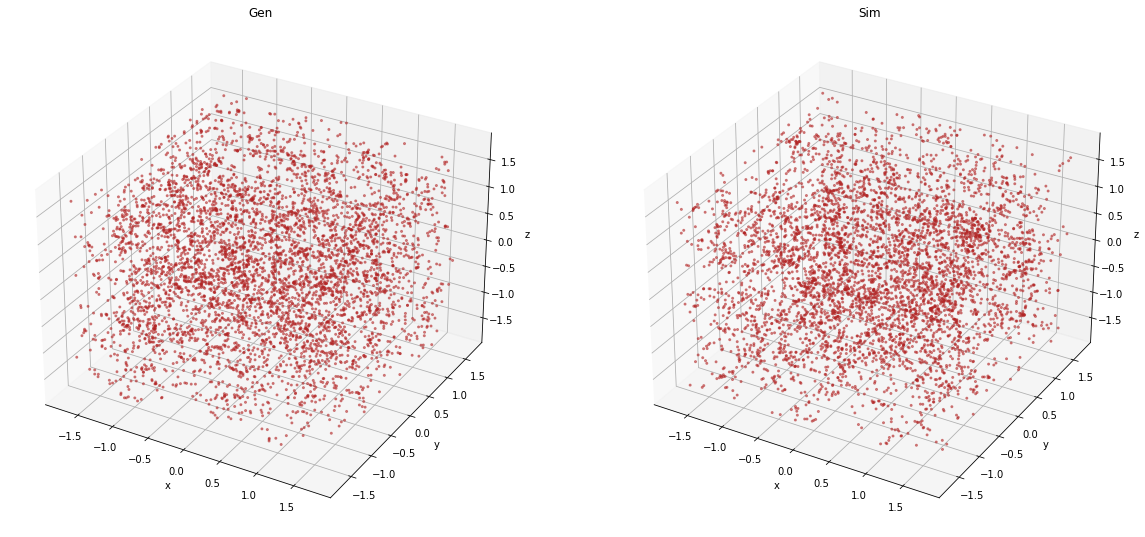

In [228]:
idx = 0

s = 4
alpha = 0.5
color = "firebrick"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection':'3d'})

ax1.scatter(x_samples[idx, :, 0], x_samples[idx, :, 1], x_samples[idx, :, 2], alpha=alpha, s=s, color=color);
ax1.set_title("Gen")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

ax2.scatter(x[idx_rnd[idx], :, 0], x[idx_rnd[idx], :, 1], x[idx_rnd[idx], :, 2], alpha=alpha, s=s, color=color);
ax2.set_title("Sim")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

In [229]:
x_rnd = jax.random.uniform(rng, shape=x[idx_rnd[idx], :config.data.n_particles, :3].shape, minval=0, maxval=1000)

Text(0, 0.5, 'y')

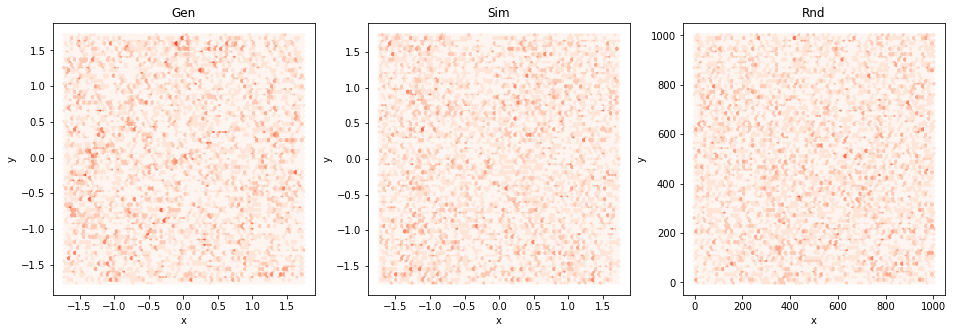

In [230]:
s = 4
alpha = 0.5
color = "firebrick"
gs = 80
cmap = "Reds"

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

vmin=0
vmax=10

ax1.hexbin(x_samples[idx, :, 0], x_samples[idx, :, 1], gridsize=gs, cmap=cmap, vmin=vmin, vmax=vmax)
ax1.set_title("Gen")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2.hexbin(x[idx, :config.data.n_particles, 0], x[idx_rnd[idx], :config.data.n_particles, 1], gridsize=gs, cmap=cmap, vmin=vmin, vmax=vmax)
ax2.set_title("Sim")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

ax3.hexbin(x_rnd[:config.data.n_particles, 0], x_rnd[:config.data.n_particles, 1], gridsize=gs, cmap=cmap, vmin=vmin, vmax=vmax)
ax3.set_title("Rnd")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

In [231]:
sys.path.append("../../ili-summarizer/")
sys.path.append("../../ili-summarizer/summarizer/")

from knn.knn import KNN
from data.catalogue import Catalogue

In [232]:
r_bins = np.linspace(0, 100, 100)
k = np.arange(1, 10)
knn = KNN(r_bins, k)

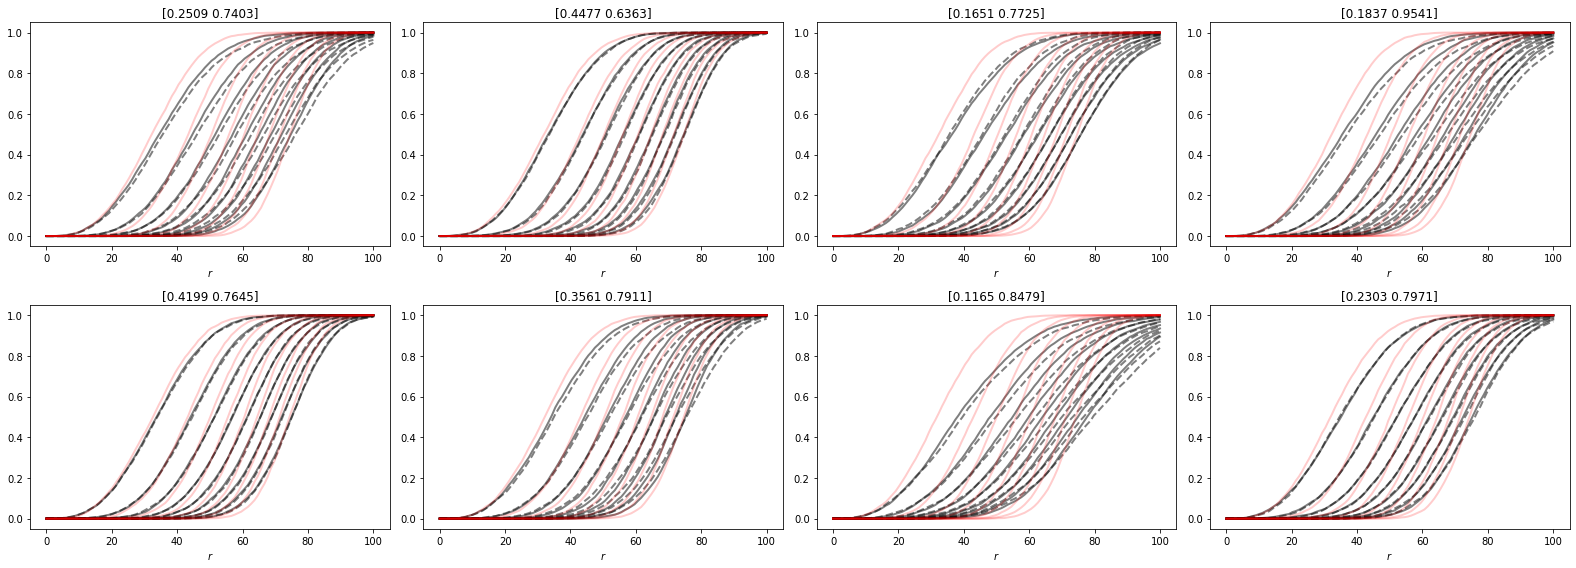

In [233]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(22, 8))
gs = GridSpec(2, 4)

for idx in range(8):
    
    ax = fig.add_subplot(gs[idx])
    
    cat = Catalogue(pos=x[idx_rnd[idx], :config.data.n_particles, :3] * x_std[:3] + x_mean[:3], vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
    knn_res = knn(cat)

    for i in range(len(knn_res)):
        plt.plot(r_bins, knn_res[i], color='k', ls='--', alpha=0.5, lw=2, label="Sim" if i == 0 else None)

    cat = Catalogue(pos=x_samples[idx, :, :3] * x_std[:3] + x_mean[:3], vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
    knn_res = knn(cat)

    for i in range(len(knn_res)):
        plt.plot(r_bins, knn_res[i], color='k', ls='-', alpha=0.5, lw=2, label="Gen" if i == 0 else None)

    cat = Catalogue(pos=x_rnd, vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
    knn_res = knn(cat)

    for i in range(len(knn_res)):
        plt.plot(r_bins, knn_res[i], color='red', ls='-', alpha=0.2, lw=2, label="Rnd" if i == 0 else None)

    ax.set_xlabel("$r$")

    ax.set_title(conditioning[idx_rnd[idx]])

plt.tight_layout()

In [234]:
# # Masses

# bins = np.linspace(13, 16, 100)
# plt.hist(vnp.array((x_samples[:, :, -1].flatten() * x_std[-1] + x_mean[-1])), bins=bins, histtype='step', label="Gen");
# plt.hist(vnp.array((x[idx_rnd, :, -1].flatten() * x_std[-1] + x_mean[-1])), bins=bins, histtype='step', label="Sim");
# plt.xlabel(r"$\log_{10}M$")
# plt.yscale("log")
# plt.legend()

In [235]:
# # Velocities

# idx = 5  # Choose a velocity component

# bins = np.linspace(-1500, 1500, 100)
# plt.hist(vnp.array((x_samples[:, :, idx].flatten() * x_std[idx] + x_mean[idx])), histtype='step', label="Gen", bins=bins);
# plt.hist(vnp.array((x[idx_rnd, :, idx].flatten() * x_std[idx] + x_mean[idx])), histtype='step', label="Sim", bins=bins);
# plt.xlabel(r"$v$")
# plt.legend()

## Likelihood eval

In [241]:
from functools import partial

In [249]:
def elbo(vdm, params, rng, x, conditioning, mask, steps=20):
    rng, spl = jax.random.split(rng)
    cond = vdm.apply(params, conditioning, method=vdm.embed)
    f = vdm.apply(params, x, conditioning, method=vdm.encode)
    loss_recon = vdm.apply(params, x, f, conditioning, rngs={"sample": rng}, method=vdm.recon_loss)
    loss_klz = vdm.apply(params, f, method=vdm.latent_loss)

    def body_fun(i, val):
        loss, rng = val
        rng, spl = jax.random.split(rng)
        new_loss = vdm.apply(params, np.array([i / steps]), f, cond, mask, rngs={"sample": spl}, method=vdm.diffusion_loss)
        return (loss + (new_loss * mask[..., None]).sum((-1, -2)) / steps, rng)

    loss_diff, rng = jax.lax.fori_loop(0, steps, body_fun, (np.zeros(x.shape[0]), rng))

    return ((loss_recon * mask[..., None]).sum((-1, -2)) + (loss_klz * mask[..., None]).sum((-1, -2)) + loss_diff)


In [250]:
@jax.jit
def likelihood(theta_test, x_test, n_samples=4):
    x_test = np.repeat(np.array([x_test]), n_samples, 0)
    theta_test = np.repeat(np.array([theta_test]), n_samples, 0)
    return -elbo(vdm, restored_state.params, rng, x_test, theta_test, np.ones_like(x_test[..., 0])).mean()

In [255]:
idx = 112

x_test = x[idx]

Omega_m = 0.05
sigma_8 = 0.9629

theta_test = np.array([Omega_m, sigma_8])
likelihood(theta_test, x_test)

Array(-23439.326, dtype=float32)

In [256]:
conditioning[idx]

Array([0.4613, 0.8533], dtype=float32)

In [257]:
sigma_8_ary = np.linspace(0.6, 1.0, 30)

log_like = []

for sigma_8 in tqdm(sigma_8_ary):
    theta_test = np.array([conditioning[idx][0], sigma_8])
    log_like.append(likelihood(theta_test, x_test))

100%|███████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.05it/s]


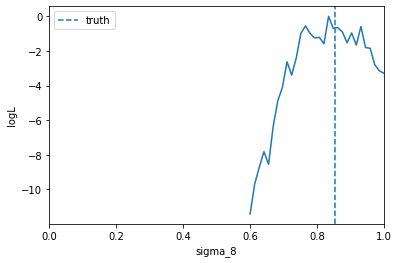

In [259]:
plt.plot(sigma_8_ary, (np.array(log_like) - np.max(np.array(log_like))))
plt.axvline(conditioning[idx][-1], ls='--', label="truth")
plt.xlim(0, 1)

plt.ylabel(r"logL")
plt.xlabel(r"sigma_8")

plt.legend()

In [260]:
def loglike(theta):
    return likelihood(theta, x_test)

def prior_cube(u):
    priors = np.array([[0.1, 0.5], [0.6, 1.]])
    priors_lo = priors[:, 0]
    priors_hi = priors[:, 1]
    priors_interval = priors[:, 1] - priors[:, 0]
    for i in range(len(u) - 1):
        u[i] = u[i] * priors_interval[i] + priors_lo[i]
    return u

def log_prior(theta):
    Omega_m, sigma_8 = theta
    if 0.1 < Omega_m < 0.5 and 0.6 < sigma_8 < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike(theta)

In [261]:
log_probability(np.array([0.3, 0.7]))

Array(-22378.322, dtype=float32)

In [278]:
import emcee
from multiprocessing import Pool

pos = np.array([0.3, 0.7]) + 1e-3 * jax.random.normal(rng, (4, 2))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████████████████| 5000/5000 [1:43:39<00:00,  1.24s/it]


In [279]:
samples = sampler.get_chain(flat=True, discard=1000)

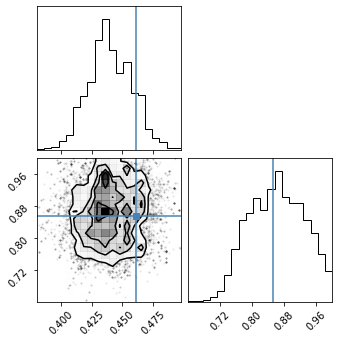

In [280]:
import corner
corner.corner(samples, truths=conditioning[idx]);

In [ ]:
import dynesty

ndim = 2

sampler = dynesty.NestedSampler(loglike, prior_cube, ndim, sample='slice')
sampler.run_nested()

2097it [2:41:03, 12.27s/it, bound: 5 | nc: 33 | ncall: 29470 | eff(%):  7.116 | loglstar:   -inf < -22326.199 <    inf | logz: -22330.226 +/-  0.079 | dlogz:  2.063 >  0.509] 

In [ ]:
import corner

results = sampler.results
samples_equal = results.samples_equal()

corner.corner(samples_equal, truths=conditioning[idx]);

In [125]:
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.distributions import constraints
from numpyro.infer import Predictive, SVI, Trace_ELBO, autoguide
from numpyro.infer import MCMC, NUTS

In [127]:
def model(x_test):
    
    # Omega_m and sigma_8 prior distributions
    params = numpyro.sample("params", dist.Uniform(np.array([0.1, 0.6]), np.array([0.5, 1.0])))
    log_like = likelihood(params, x_test)

    return numpyro.factor('log_like', log_like)

In [131]:
# n_steps = 10
# lr = 1e-2

# guide = autoguide.AutoMultivariateNormal(model)
# optimizer = optim.optax_to_numpyro(optax.sgd(lr))
# svi = SVI(model, guide, optimizer, Trace_ELBO(num_particles=1))
# svi_results = svi.run(rng, n_steps, x_test)

In [54]:
# num_samples = 1000
# num_chains = 1
# kernel = NUTS(model)
# mcmc = MCMC(kernel, num_warmup=50, num_samples=num_samples, num_chains=num_chains, chain_method='vectorized')
# mcmc.run(rng, x_test)

## Save samples

In [174]:
np.savez("/n/holystore01/LABS/iaifi_lab/Users/smsharma/set-diffuser/data/nbody_samples.npz",
         x_true=x[idx_rnd] * x_std + x_mean,
         x_samples=x_samples * x_std + x_mean,
         cosmology=conditioning[idx_rnd])

## Generate samples from same cosmology

In [120]:
omega_m = 0.2  # Set parameters
sigma_8 = 0.7

cosmology = np.mean(conditioning, axis=0)

cosmology = cosmology.at[0].set(omega_m)
cosmology = cosmology.at[-1].set(sigma_8)

In [121]:
n_samples = 10  # How many samples from same cosmology

rng = jax.random.PRNGKey(33)
x_samples_cosmo = generate(vdm, restored_state.params, rng, (n_samples, config.data.n_particles), conditioning=np.repeat(np.array([cosmology]), n_samples, 0), mask=np.ones((n_samples, config.data.n_particles)))
x_samples_cosmo = x_samples_cosmo.mean()

Text(0.5, 0, 'z')

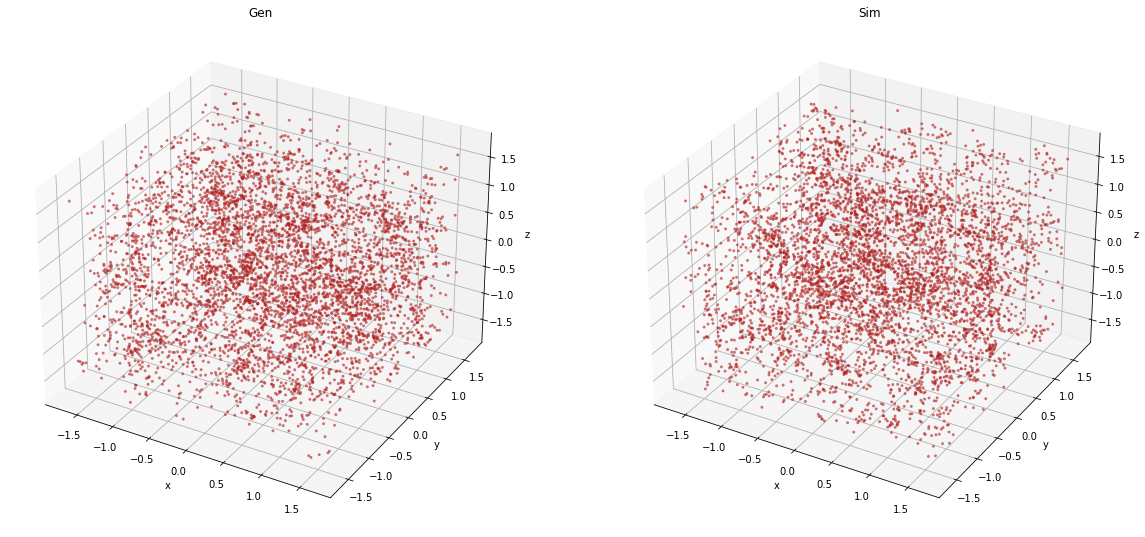

In [122]:
s = 4
alpha = 0.5
color = "firebrick"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection':'3d'})

idx = 0
ax1.scatter(x_samples_cosmo[idx, :, 0], x_samples_cosmo[idx, :, 1], x_samples_cosmo[idx, :, 2], alpha=alpha, s=s, color=color);
ax1.set_title("Gen")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

idx = 1
ax2.scatter(x_samples_cosmo[idx, :, 0], x_samples_cosmo[idx, :, 1], x_samples_cosmo[idx, :, 2], alpha=alpha, s=s, color=color);
ax2.set_title("Sim")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")